<a href="https://colab.research.google.com/github/geoffwoollard/prob_prog/blob/main/project/pyro_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip3 install pyro-ppl 

     |████████████████████████████████| 678 kB 5.2 MB/s 


In [ ]:
import pyro
import torch
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pandas as pd

def doplt(arr_2d): return plt.imshow(arr_2d, cmap='gray')
pyro.set_rng_seed(101)


# 1D gaussian signal with shift
* gaussian pixelated noise $\sigma_{noise}$
* prior of shift is gaussian with fixed and known params  $\mu_{shift}, \sigma_{shift}$

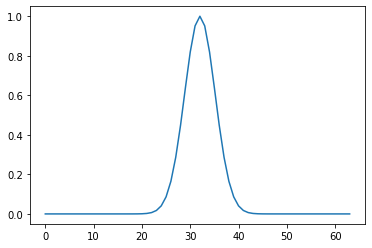

In [ ]:
num_pix = 64
domain = torch.arange(-num_pix//2, num_pix//2)
sigma_signal = 10
clean_signal = torch.exp(-domain**2/(2*sigma_signal))
pd.Series(clean_signal).plot()

In [ ]:
# synthetic data. normally, these would come from actual measurements and we would not know shift. h
# ere we have access to the ground truth
sigma_noise = 0.1
num_particles = 1000
data = torch.empty((num_particles,num_pix))
for i in range(num_particles):
  shift = dist.Normal(0,2).sample()
  clean_signal = torch.exp(-(domain-shift)**2/(2*sigma_signal))
  data[i] = dist.Normal(clean_signal,sigma_noise).sample()

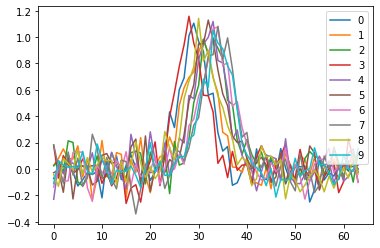

In [ ]:
pd.DataFrame(data[:10].numpy().T).plot()

In [ ]:
# def model(data):
#   batch_size=1
#   shift = pyro.sample('shift',dist.Normal(0,2))
#   clean_signal = torch.exp(-(domain-shift)**2/(2*sigma_signal))
#   for i in pyro.plate("data", size=len(data), subsample_size=batch_size):
#     pyro.sample("particle_1d_%d"%i, dist.Normal(clean_signal, sigma_noise).to_event(1), obs=data[i])

def model(data):
  batch_size=10
  shift = pyro.sample('shift',dist.Normal(0,2)) # TODO: what if we don't know 0,2 here, we just use best guess
  clean_signal = torch.exp(-(domain-shift)**2/(2*sigma_signal))
  with pyro.plate("data", size=len(data), subsample_size=batch_size) as ids:
    pyro.sample("particle_1d", dist.Normal(clean_signal, sigma_noise).to_event(1), obs=data[ids])

In [ ]:
def guide(data): # the proposal distribution
  """
  learn the parameters of our modelled encoding of the signal (a 1D atom)
  hard coded fixed noise of 0.1
  """
  shift_mean = pyro.param("shift_mean", torch.tensor(0.))
  shift_std = pyro.param("shift_std", torch.tensor(2.), constraint=torch.distributions.constraints.positive)
  shift = pyro.sample('shift',dist.Normal(shift_mean,shift_std))

In [ ]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model, # takes in guess, returns sample of weight
                     guide=guide, # takes in guess, returns sample of weight
                     optim=pyro.optim.Adam({"lr": 0.003}), # the optimizer
                     loss=pyro.infer.Trace_ELBO())

shift_mean =  -0.03807112202048302
shift_std =  1.6731318235397339


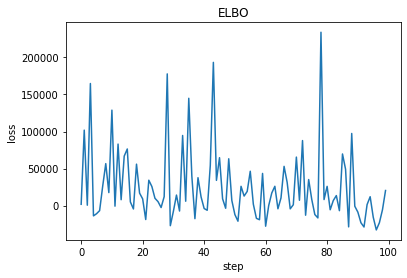

In [ ]:
losses, shift_mean, shift_std = [], [], []
num_steps = 100
for t in range(num_steps):
    losses.append(svi.step(data))
    shift_mean.append(pyro.param("shift_mean").item())
    shift_std.append(pyro.param("shift_std").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('shift_mean = ',pyro.param("shift_mean").item())
print('shift_std = ',pyro.param("shift_std").item())

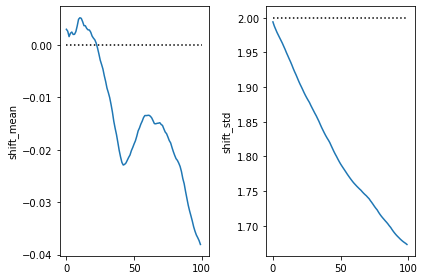

In [ ]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[0,0], 'k:')
plt.plot(shift_mean)
plt.ylabel('shift_mean')
plt.subplot(1,2,2)
plt.ylabel('shift_std')
plt.plot([0,num_steps],[2,2], 'k:')
plt.plot(shift_std)
plt.tight_layout()